# Implementation of softmax and derivative test

Defining variables   
- $\textbf{C}_{\text{obs}}$ is a $n_c \times n$ labels matrix 
- $\textbf{W}$ is a $n_c \times n_f$ weights and biases matrix 
- $\textbf{Y}$ is a $n_f \times n$ observation matrix 

Cross entropy is defined as

\begin{gather}
E(\textbf{C}_{\text{obs}}, \textbf{S})=-\frac{1}{n}\textbf{e}^\top_{n_c}(\textbf{C}_{\text{obs}} \odot \textbf{S}) \textbf{e}_n + 
\frac{1}{n}\log(\textbf{e}^\top_{n_c}\exp(\textbf{S}))\textbf{e}_n
\end{gather}

In the actual python code, we can simply code the matrix multiplication with the vector of ones on each side with just 
summing up all of the elements in the matrix of interest.

In [1]:
import autograd.numpy as np
import autograd
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
def softmaxFun(W, Y, C):
    """
    Computes softmax objective function and necessary components to optimize
    
    Parameters:
        W -- the weights of the classifier as a vector (n_c * n_f) x 1. Even though the weights are 
             really used as a matrix, a vector makes the gradient and Hessian calculations simpler.
        Y -- the features, including bias if needed (n_f x n)
        C -- the labels, (n_c x n)
    
    Returns:
        E -- the cross entropy for weights W
        dE -- the gradient as a vector of length (n_c * n_f)
        d2E -- a function with one input that computes a MVP with the Hessian
    """
    n_f = Y.shape[0]
    n_c, n = C.shape
    
    # The "C" parameter to the order arg tells reshape to follow C-index, or fill in the ndarray along the rows
    # The "F" argument would reshape following Fortran index, so filling in the ndarray along the columns. MATLAB
    W_mat = np.reshape(W, newshape = (n_c, n_f), order = "C")
    S = W_mat @ Y
    
    # Cross-entropy calculation
    def cross_entropy(W):
        S = W @ Y
        # Prevent overflow and underflow
        s = np.max(S, axis=0)
        S = S - s
        return -(1/n) * np.sum(np.sum(np.multiply(C, S),  axis=0)) + (1/n) * np.sum(np.log(np.sum(np.exp(S), axis=0)))
    
    # Gradient using auto-differentiation
    def gradient(W):
        g = autograd.grad(cross_entropy)
        return np.reshape(g(W), newshape = (n_c*n_f, 1), order = "C")
    
    # Make sure entropy is scalar and not (1 x 1) matrix
    E = cross_entropy(W_mat)
    dE = gradient(W_mat)
    
    # Hessian-vector product using useful identity
    def d2E(v):
        return autograd.grad(np.vdot(gradient, v))
        
    return E, dE, d2E

### Testing derivatives using Taylor's Theorem

Plot the below two functions for values of $h$ between 0 and 1. Plot on the log-log scale and verify the top has a slope of 1, 
and the bottom has a slope of 2. This test is very clever. We compute the following errors

\begin{gather}
y_1=E(\textbf{W}+h\textbf{D})-E(\textbf{W}) \\
y_2=E(\textbf{W}+h\textbf{D})-E(\textbf{W})-h\text{tr}(\textbf{D}^\top\nabla E(\textbf{W}))
\end{gather}

To get at why the test works, set $w=\log(y)$ and $z=\log(h)$. If our first derivative is incorrect then

\begin{gather}
w=z+\log\left([f_{true}'(W)-f'_{g}(W)]+\sum^k_{i=2}\frac{f^{(i)}(W)}{i!}e^{z(i-1)} \right) \\
\end{gather}

If the error in our derivative is 0, then it should like a line with slope 2, with some added nonlinear term that increases in value at higher values of $z$. However in our case, since $z=\log h$, $z\in(-\infty,0]$ and that right term will be negligible
\begin{gather}
w=2z+\log\left(\frac{f''(W)}{2}+\sum^k_{i=3}\frac{f^{(i)}(W)}{i!}e^{z(i-1)}\right)  
\end{gather}

In [15]:
# Set up necessary variables, W, Y, C, D, h
n = 500
n_c = 6
n_f = 10
Y = np.random.normal(0,1,(n_f, n))
W = np.ones((n_c * n_f, 1))
D = np.random.normal(0,1,(n_c * n_f, 1))
A = np.random.normal(0,1,(n_c, n))
C = np.zeros((n_c, n))
for j in range(A.shape[1]):
    i = np.argmax(C[:,j])
    C[i,j] = 1

In [16]:
# Function and its gradient I'm testing
def f(W, Y, C):
    return softmaxFun(W, Y, C)[0]

def f_grad(W, Y, C):
    return softmaxFun(W, Y, C)[1]

In [17]:
def derivativeTest(f, f_grad, h, W, D, **kwargs):
    """
    Conducts the derivative test based on Taylor's Theorem. Outputs the differences of interest
    for each value of 'h' step size provided. 

    Parameters
        f -- Function to be evaluated
        f_grad -- Function for the derivative of f
        h -- Step sizes, must be in (0,1]
        W -- Fixed constant to evaluate the function at 
        h -- step size
        D -- direction to move in from W
        **kwargs -- any other keyword arguments needed to evaluate f(x) and f_grad(x)
    
    Returns
        d1 -- Function error: f(W + hD) - f(W)
        d2 -- Derivative error:  f(W + hD) - f(W) - f'(W)hD
    """
    
    d1 = np.zeros(len(h))
    d2 = np.zeros(len(h))
        
    for i in range(len(h)):
        E_hD = f(W + h[i]*D, **kwargs)
        E_W = f(W, **kwargs)
        grad_E = f_grad(W, **kwargs)
        d1[i] = E_hD - E_W
        if np.isscalar(W):
            # If just a function taking scalar inputs
            d2[i] = E_hD - E_W - (h[i]*D)*grad_E
        else:
            # If a function taking vector inputs (or vec(matrix))
            d2[i] = E_hD - E_W - h[i]*np.trace(D @ grad_E.T)

    return abs(d1), abs(d2)

In [18]:
h = np.array([2e-10, 2e-8, 2e-7, 2e-6, 2e-5, 2e-4, 2e-3, 2e-1, 1])
d1, d2 = derivativeTest(f, f_grad, h, W, D, Y=Y, C=C)

Text(0, 0.5, '$\\log(\\Delta E)$')

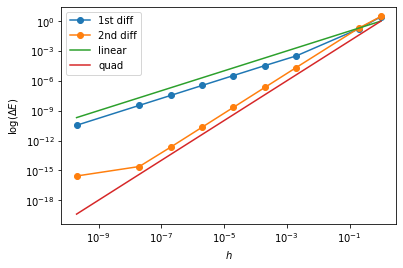

In [19]:
plt.plot(h, abs(d1), marker="o", label="1st diff")
plt.plot(h, abs(d2), marker="o", label="2nd diff")
plt.plot(h, h, label="linear")
plt.plot(h, h**2, label="quad")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
plt.ylabel("$\log(\Delta E)$")

In [34]:
# Should be slopes close to 1 at the smallest values of h
np.diff(np.log(d1)) / np.diff(np.log(h))

array([1.00000174, 0.9999985 , 0.99998438, 0.99984379, 0.99843479,
       0.98402601, 1.24257928, 1.84093145])

In [35]:
# Should be slopes close to 2 at the smallest values of h
np.diff(np.log(d2)) / np.diff(np.log(h))

array([0.40322737, 1.86400628, 1.99932449, 1.99998877, 2.00000881,
       2.00008764, 1.99657404, 1.71113207])

The gradient looks good! Still need to test the Hessian...

### Softmax tests to perform
1. Scalar result for cross entropy always
2. Result does not depend on order of columns of $\textbf{Y}$
3. Result should be the same for both ($\textbf{y, c}$) or $(\textbf{ye}^\top, \textbf{ce}^\top)$
4. $\textbf{W}=\alpha\textbf{I}$ and $\textbf{Y=C}$ don't cause overflow for any $\alpha$

Text(0.5, 1.0, 'Test Problem: Linearly Separable classes')

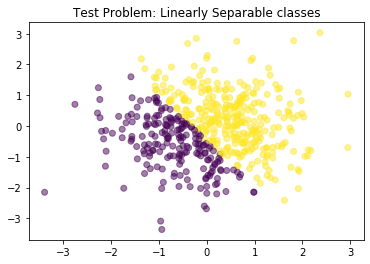

In [5]:
n = 500
n_c = 2
n_f = 2

a = 3; b = 2
Y = np.random.normal(0,1,(n_f, n))
C = a*Y[0,:] + b*Y[1,:] + 1
C[C>0] = 1; C[C<0] = 0
C_mat = np.array([C, 1-C])
W = np.zeros((n_c, n_f))

plt.scatter(Y[0,:], Y[1,:], alpha=0.5, c=C)
plt.title("Test Problem: Linearly Separable classes")